## Import Modules and Libraries

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

Importing the training data and creating training and validation datasets.

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (300, 300)
train_dir = './Mushrooms'

# Step 1: Collect all file paths and labels manually
class_names = sorted(os.listdir(train_dir))
class_to_index = {name: idx for idx, name in enumerate(class_names)}

import json

with open('label_map.json', 'w') as f:
    json.dump(class_to_index, f)

filepaths = []
labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for fname in os.listdir(class_path):
        filepaths.append(os.path.join(class_path, fname))
        labels.append(class_to_index[class_name])

# Step 2: Split into train and val
data = list(zip(filepaths, labels))
np.random.shuffle(data)
split = int(len(data) * 0.8)
train_data, val_data = data[:split], data[split:]

# Step 3: Image decoding with try-catch inside the data pipeline
def load_and_preprocess(path, label):
    def _load(path_str):
        try:
            img_raw = tf.io.read_file(path_str)
            img = tf.image.decode_jpeg(img_raw, channels=3)
            img = tf.image.resize(img, IMG_SIZE)
            return img
        except:
            return tf.zeros([*IMG_SIZE, 3])  # Return black image on error

    img = tf.py_function(_load, [path], tf.float32)
    img.set_shape([*IMG_SIZE, 3])
    return img, label

def make_dataset(data_list):
    paths, labels = zip(*data_list)
    ds = tf.data.Dataset.from_tensor_slices((list(paths), list(labels)))
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = make_dataset(train_data)
validation_dataset = make_dataset(val_data)

Display of Randon Mushrooms from Dataset

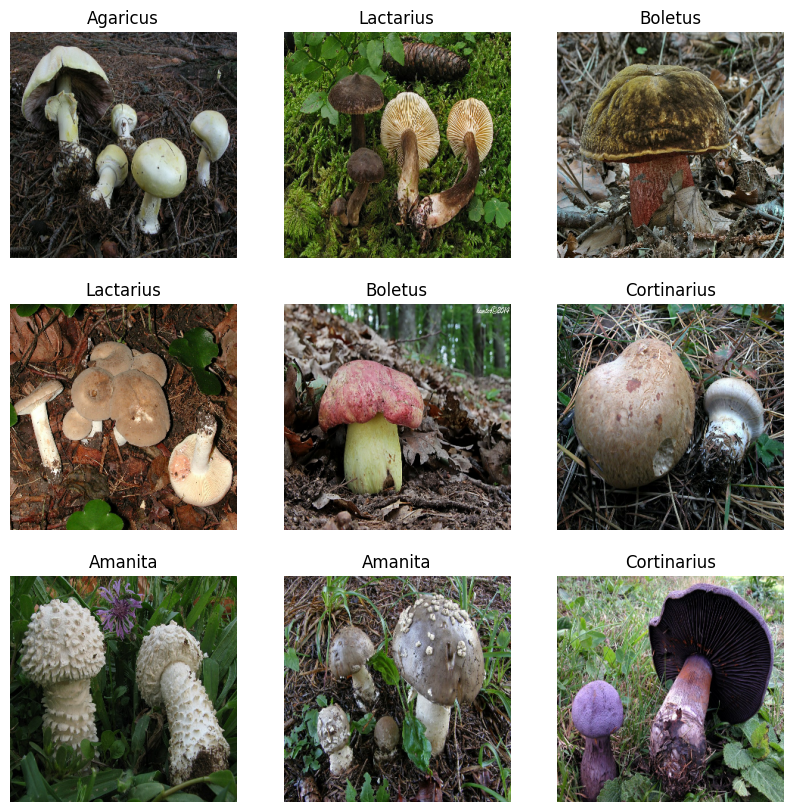

In [4]:

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 34
Number of test batches: 8


## Data Augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomZoom(0.4),
    tf.keras.layers.RandomContrast(0.5),
    tf.keras.layers.RandomTranslation(0.3, 0.3),
    tf.keras.layers.RandomBrightness(0.3),
    tf.keras.layers.RandomHeight(0.3),
    tf.keras.layers.RandomWidth(0.3)
])


## Data Augmentation training

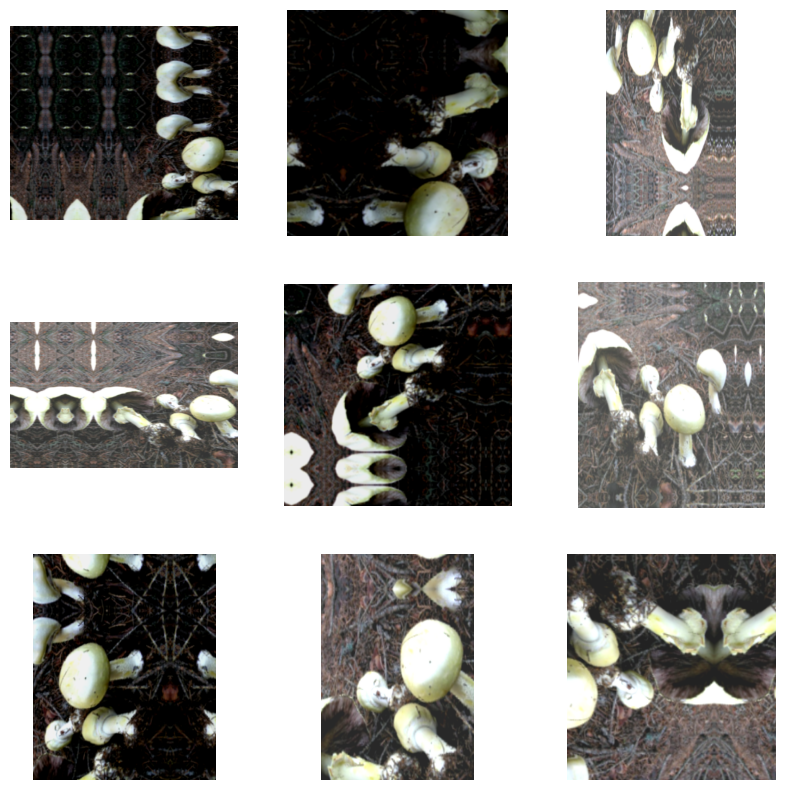

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Loading the EfficientNetB0 Model

In [10]:
# Load base model
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True  # unfreeze the model

# Freeze the bottom layers, fine-tune top ones
for layer in base_model.layers[:100]:
    layer.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                         patience=3, min_lr=1e-6)
]


In [11]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:

inputs = tf.keras.Input(shape=(300, 300, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,061,100 (15.49 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
len(model.trainable_variables)
# tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,061,100 (15.49 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Training the Epochs and Unfreezing layers

In [15]:
# Phase 1: Initial training with frozen base
initial_epochs = 15
loss0, accuracy0 = model.evaluate(validation_dataset)
print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

history_initial = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs
)

# Phase 2: Fine-tuning - unfreeze top layers
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_finetune = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=history_initial.epoch[-1]
)

34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.1376 - loss: 2.1831
Initial loss: 2.18
Initial accuracy: 0.15
Epoch 1/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.1844 - loss: 2.1330 - val_accuracy: 0.3137 - val_loss: 1.9357
Epoch 2/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.3301 - loss: 1.8687 - val_accuracy: 0.4020 - val_loss: 1.8040
Epoch 3/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.3900 - loss: 1.7281 - val_accuracy: 0.4499 - val_loss: 1.7038
Epoch 4/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.4379 - loss: 1.6181 - val_accuracy: 0.4729 - val_loss: 1.6225
Epoch 5/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.4628 - loss: 1.5399 - val_accuracy: 0.5069 - val_loss: 1.5565
Epoch 6/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.4955 - loss: 1.4755 - val_accuracy: 0.5253 - val_loss: 1.5018
Epoch 7/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.5059 - loss: 1.4150 - val_accuracy: 0.5391 -

## Plotting

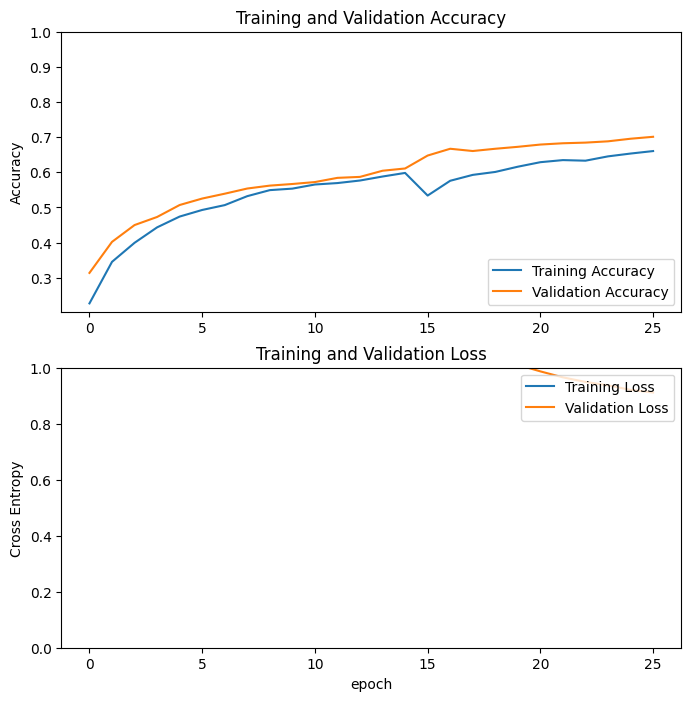

In [16]:
acc = history_initial.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_initial.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_initial.history['loss'] + history_finetune.history['loss']
val_loss = history_initial.history['val_loss'] + history_finetune.history['val_loss']

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Freeze layers

In [17]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  238


In [18]:
# Compile the model for multi-class classification
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
              metrics=['accuracy'])  # Use this for integer labels

model.summary()
len(model.trainable_variables)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,061,100 (15.49 MB)

 Trainable params: 2,538,393 (9.68 MB)

 Non-trainable params: 1,522,707 (5.81 MB)

47

## Fine Tuning

In [19]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history_initial.epoch),
                         validation_data=validation_dataset)
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']





Epoch 16/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.6513 - loss: 1.0474 - val_accuracy: 0.7102 - val_loss: 0.8853
Epoch 17/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.6752 - loss: 1.0053 - val_accuracy: 0.7121 - val_loss: 0.8649
Epoch 18/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.6658 - loss: 0.9795 - val_accuracy: 0.7176 - val_loss: 0.8448
Epoch 19/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.6816 - loss: 0.9461 - val_accuracy: 0.7268 - val_loss: 0.8233
Epoch 20/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.6974 - loss: 0.9233 - val_accuracy: 0.7369 - val_loss: 0.8070


## Test 1: Predict Correct Mushrooms

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7014 - loss: 0.8619
Test accuracy : 0.7265625
Predictions shape: (32, 9)
Labels:
 tf.Tensor([7 4 4 6 2 6 7 6 7 7 0 1 3 2 7 7 7 3 7 4 7 3 6 6 2 3 6 3 3 2 2 3], shape=(32,), dtype=int32)


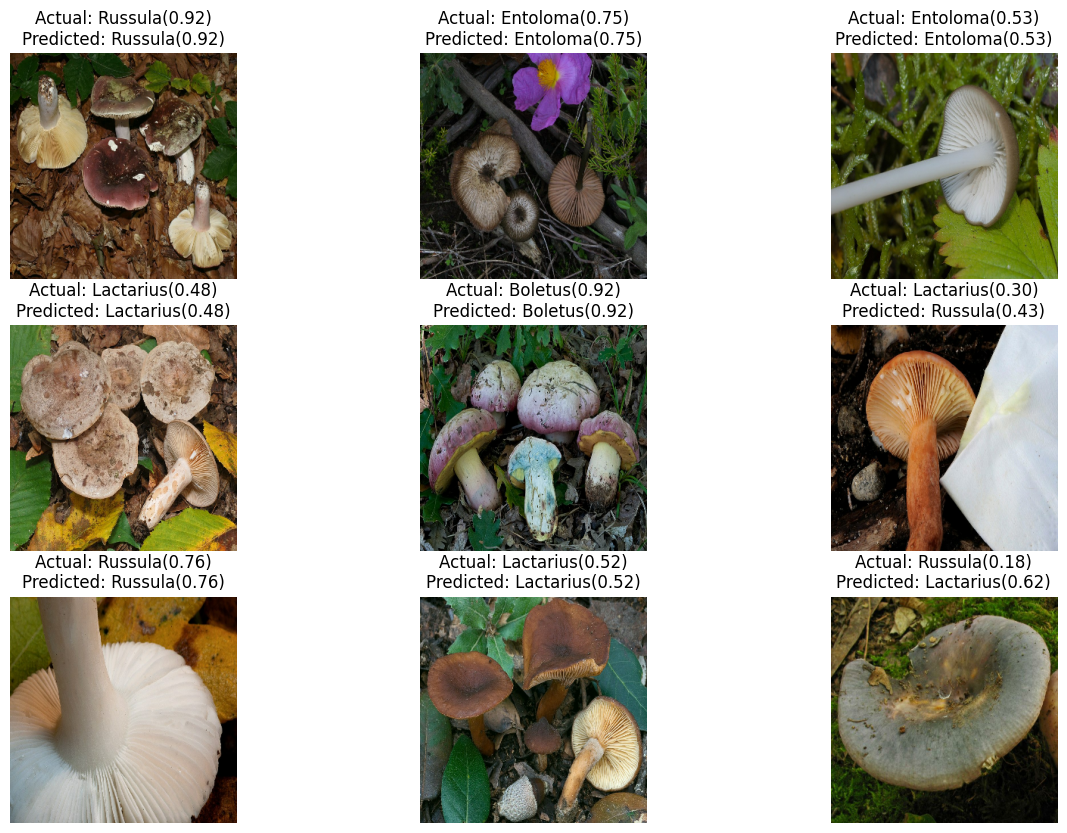

In [20]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
# Retrieve a batch of images from the test set
# Retrieve a batch of images and labels from the test dataset
image_batch, label_batch = next(iter(test_dataset))

# Make predictions on the batch of images
predictions = model.predict_on_batch(image_batch)

# Check the shape of predictions; it should be (batch_size, 13)
print("Predictions shape:", predictions.shape)

# Use np.argmax to get the class index with the highest probability for each image
predicted_classes = np.argmax(predictions, axis=1)

# Now you can print the shape and work with the
print('Labels:\n', label_batch)


def plot_images(images, labels, predicted_classes):
    plt.figure(figsize=(15, 10))
    for i in range(9):  # Display 9 images
        plt.subplot(3, 3, i + 1)
        # Convert the image to a NumPy array and then use astype("uint8")
        true_class = labels[i]
        predicted_class = predicted_classes[i]
        true_class_prob = predictions[i][true_class]
        predicted_class_prob = predictions[i][predicted_class]
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[labels[i]]}({true_class_prob:.2f})\nPredicted: {class_names[predicted_classes[i]]}({predicted_class_prob:.2f})")
        plt.axis("off")
    plt.show()

# Call the function to plot images
plot_images(image_batch, label_batch, predicted_classes)


## Test 2: Predict Incorrect Mushrooms

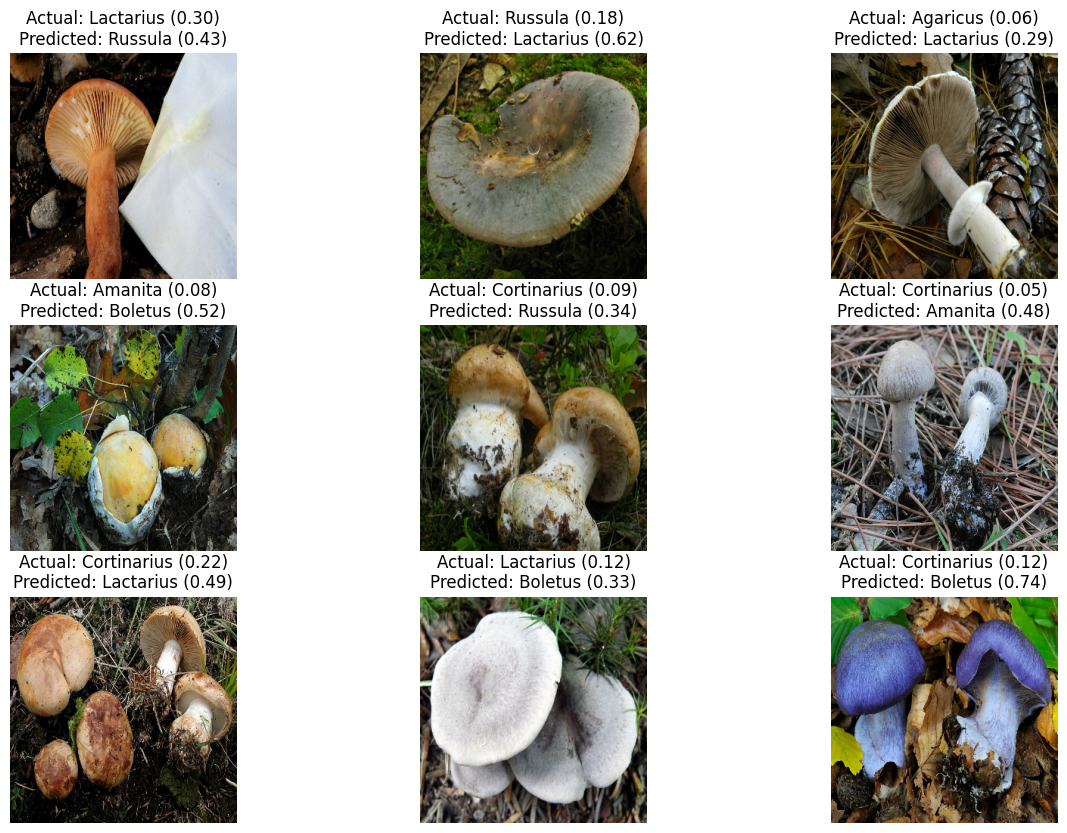

In [21]:
def plot_incorrect_predictions_with_probs(images, labels, predicted_classes, predictions):
    # Find indices where the predictions are incorrect
    incorrect_indices = [i for i in range(len(labels)) if labels[i] != predicted_classes[i]]

    # If there are fewer than 9 incorrect images, display all of them
    num_images_to_display = min(9, len(incorrect_indices))

    plt.figure(figsize=(15, 10))
    for index in range(num_images_to_display):
        i = incorrect_indices[index]  # Get the index of the incorrect prediction
        
        # Get the true class and the predicted class
        true_class = labels[i]
        predicted_class = predicted_classes[i]
        
        # Get the probabilities for the true and predicted classes
        true_class_prob = predictions[i][true_class]
        predicted_class_prob = predictions[i][predicted_class]

        # Plot the image
        plt.subplot(3, 3, index + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[true_class]} ({true_class_prob:.2f})\n"
                  f"Predicted: {class_names[predicted_class]} ({predicted_class_prob:.2f})")
        plt.axis("off")
    plt.show()

# Call the function to plot 9 incorrectly predicted images with probabilities
plot_incorrect_predictions_with_probs(image_batch, label_batch, predicted_classes, predictions)

## Generate the Model

In [22]:
# Save the model
model.save('my_model.keras')  # This saves architecture + weights together (Keras used as .h5 had issues)
print('Model saved as my_model.keras')


Model saved as my_model.keras
